################ IMPORT LIBRARIES ################

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

from config import (
    RF_MODEL_PATH_PL_DIR, RF_MODEL_PATH_ALL, 
    DB_PATH, DB_PATH_PL_DIR, DB_PATH_ALL
    )

################ UTILS FUNCTIONS ################

In [14]:
def load_data(path):
    if path.endswith(".parquet"):
        return pd.read_parquet(path)
    elif path.endswith(".csv"):
        return pd.read_csv(path)
    else:
        raise ValueError("File format not supported: use CSV or Parquet.")
    
def load_or_train_model(X_train, y_train, model_path, path):
    if os.path.exists(model_path):
        print(f"✅ Model loaded from {model_path}.")
        return joblib.load(model_path)
    else:
        trained_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
        trained_model.fit(X_train, y_train)
        joblib.dump(trained_model, path)
        return trained_model

def evaluate_model(trained_model, X_test, y_test):
    y_pred = trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"### Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    per_class = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])
    return per_class.style.background_gradient(subset=["precision", "recall", "f1-score"], cmap="Greens")

def plot_confusion_matrix(trained_model, X_test, y_test):
    y_pred = trained_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true') * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues', ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    print("Confusion Matrix")
    plt.show()

def plot_distributions(df):
    print("Classes distribution (LABEL & LABEL-bin)")
    fig1, ax1 = plt.subplots()
    sns.countplot(x='LABEL', data=df, ax=ax1)
    ax1.set_title('Classes distribution - LABEL')
    ax1.set_yscale('log')
    plt.show()

    if 'LABEL-bin' in df.columns:
        fig2, ax2 = plt.subplots()
        sns.countplot(x='LABEL-bin', data=df, ax=ax2)
        ax2.set_title('Classes distribution - LABEL-bin')
        ax2.set_yscale('log')
        plt.show()

def plot_feature_importances(trainde_model, feature_names):
    print("### ⭐ Feature Importances")
    feat_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": trainde_model.feature_importances_
    }).sort_values(by="Importance", ascending=False).head(10)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=feat_imp, x="Importance", y="Feature", ax=ax)
    ax.set_title("Top 10 Feature Importances")
    plt.show()

def analyze_mtu_packets(df):
    print("📊 Analysis: Biflow with at least one packet with MTU > 1500 bytes")
    if 'PL' in df.columns:
        mtu_count = df['PL'].apply(lambda pkt_list: 1500 in pkt_list).sum()
        print(f"There are {mtu_count} over {len(df)} total biflow with at least one MTU packet (1500 bytes).")
    else:
        print("'PL' column is not available in the dataset.")

df_unprocessed = load_data(DB_PATH)

################ BOXPLOT ################

### Labels count:
- **DDoS**: 121831
- **Probe**: 60332
- **Normal**: 23532
- **DoS**: 18883
- **BFA**: 939
- **Web-Attack**: 91


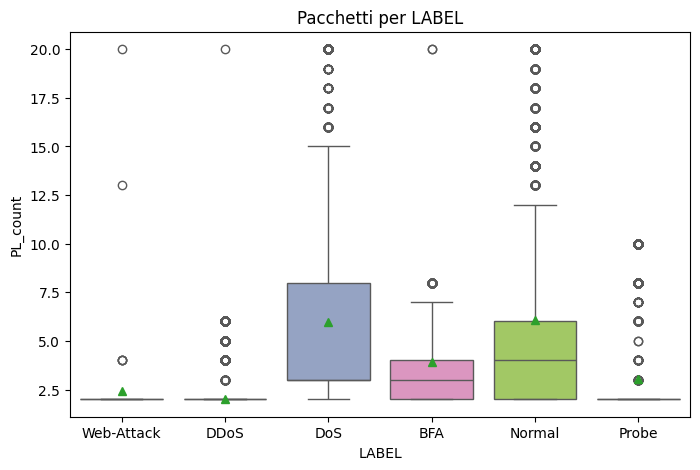

In [ ]:
label_count = df_unprocessed["LABEL"].value_counts()
markdown_label_count = "\n".join([f"- {k}: {v}" for k, v in label_count.items()])
print(f"### Labels count:\n{markdown_label_count}")
df_unprocessed["PL_count"] = df_unprocessed["PL"].apply(len)
df_unprocessed["PL_first"] = df_unprocessed["PL"].apply(lambda x: x[0] if len(x) > 0 else None)
df_unprocessed["PL_second"] = df_unprocessed["PL"].apply(lambda x: x[1] if len(x) > 1 else None)

fig1, ax1 = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_unprocessed, x='LABEL', y='PL_count', palette='Set2', hue = 'LABEL', showmeans=True, ax=ax1, legend=False)
ax1.set_title('Pacchetti per LABEL')
plt.show()

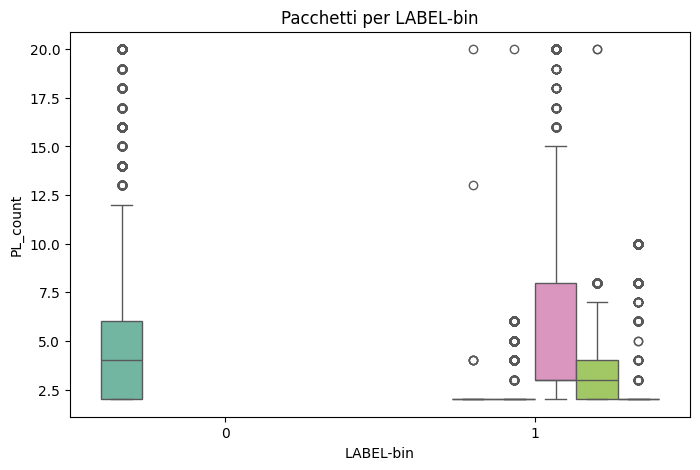

In [39]:
fig2, ax2 = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_unprocessed, x='LABEL-bin', y='PL_count', hue='LABEL', palette='Set2',  ax=ax2, legend=False)
ax2.set_title('Pacchetti per LABEL-bin')
plt.show()

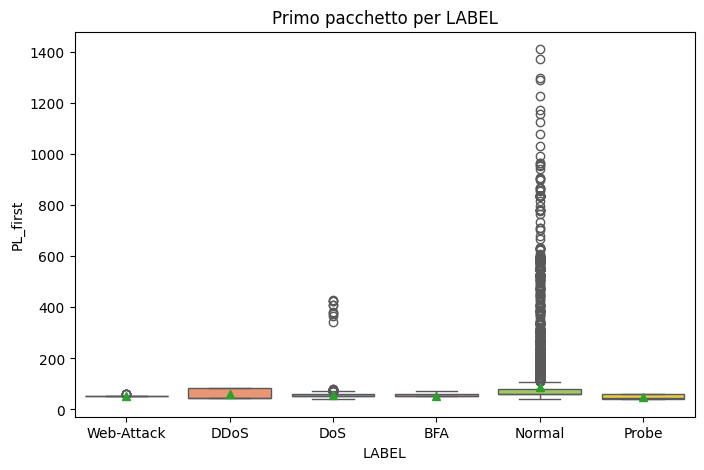

In [40]:
fig3, ax3 = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_unprocessed, x='LABEL', y='PL_first', hue = 'LABEL', palette='Set2', showmeans=True, ax=ax3, legend=False)  
ax3.set_title('Primo pacchetto per LABEL')
plt.show()

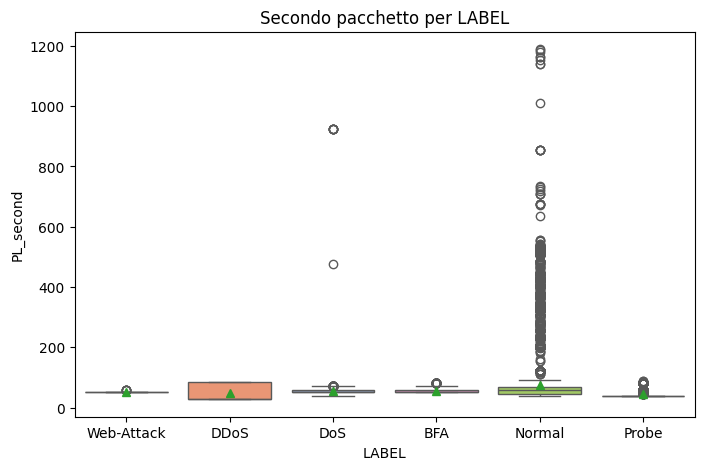

In [50]:
fig4, ax4 = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_unprocessed, x='LABEL', y='PL_second', hue ='LABEL', palette='Set2', showmeans=True, ax=ax4, legend=False)  
ax4.set_title('Secondo pacchetto per LABEL')
plt.show()

################ DATASET WITH ONLY PL&DIR FEATURES ################

✅ Model loaded from model/random_forest_model_pl_dir.joblib.
Classes distribution (LABEL & LABEL-bin)


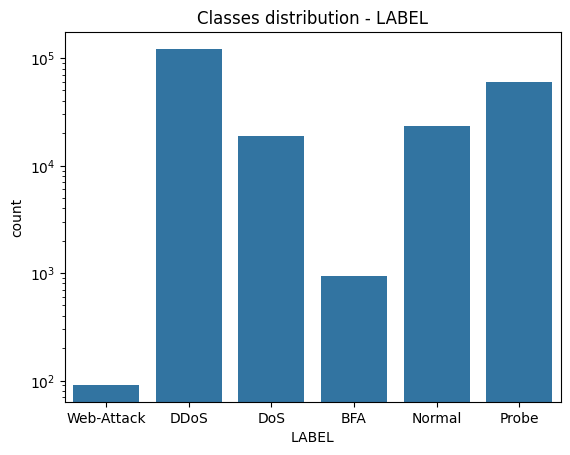

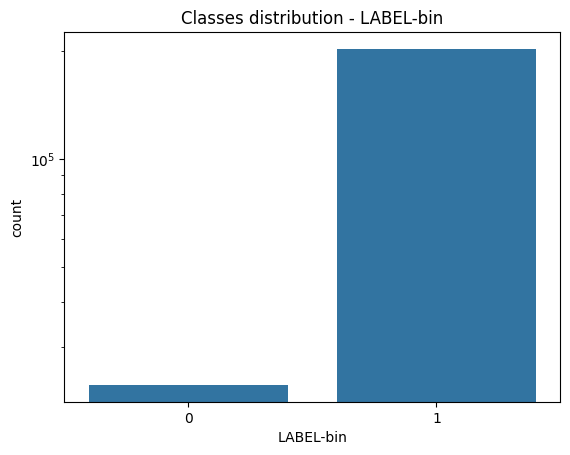

In [ ]:
df_PL_DIR = load_data(DB_PATH_PL_DIR)
X, y = df_PL_DIR, df_unprocessed['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
trained_model = load_or_train_model(X_train, y_train, RF_MODEL_PATH_PL_DIR, DB_PATH_PL_DIR)

plot_distributions(df_unprocessed)

################ RANDOM FOREST MODEL ################

In [52]:
evaluate_model(trained_model, X_test, y_test)

### Accuracy: 0.9960
Classification Report:


,precision,recall,f1-score,support
BFA,0.724138,0.335106,0.458182,188.000000
DDoS,1.000000,0.999959,0.999979,24366.000000
DoS,0.978312,0.991263,0.984745,3777.000000
Normal,0.999575,0.999788,0.999681,4706.000000
Probe,0.993985,0.999669,0.996819,12067.000000
Web-Attack,0.000000,0.000000,0.000000,18.000000


Confusion Matrix


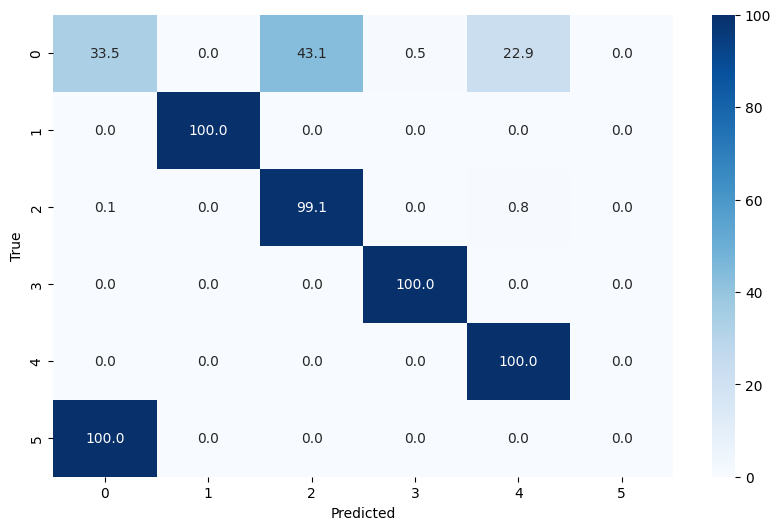

In [53]:
plot_confusion_matrix(trained_model, X_test, y_test)

### ⭐ Feature Importances


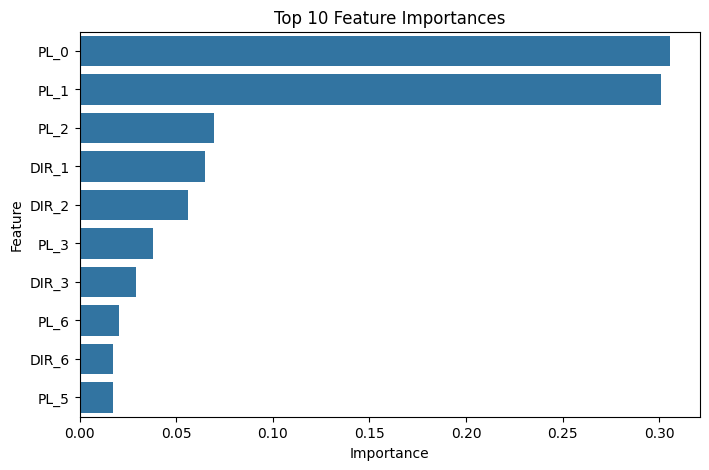

In [54]:
plot_feature_importances(trained_model, X.columns)

In [55]:
analyze_mtu_packets(df_unprocessed)

📊 Analysis: Biflow with at least one packet with MTU > 1500 bytes
There are 8875 over 225608 total biflow with at least one MTU packet (1500 bytes).


################ DATASET WITH ALL FEATURES ################


In [ ]:
df_PL_DIR = load_data(DB_PATH_ALL)
X, y = df_PL_DIR, df_unprocessed['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
trained_model = load_or_train_model(X_train, y_train, RF_MODEL_PATH_ALL, DB_PATH_ALL)

evaluate_model(trained_model, X_test, y_test)

✅ Model loaded from model/random_forest_model_all_features.joblib.
### Accuracy: 0.9986
Classification Report:


,precision,recall,f1-score,support
BFA,0.993789,0.851064,0.916905,188.000000
DDoS,1.000000,1.000000,1.000000,24366.000000
DoS,0.998666,0.991263,0.994951,3777.000000
Normal,0.999788,0.999788,0.999788,4706.000000
Probe,0.995215,0.999751,0.997478,12067.000000
Web-Attack,1.000000,1.000000,1.000000,18.000000


Confusion Matrix


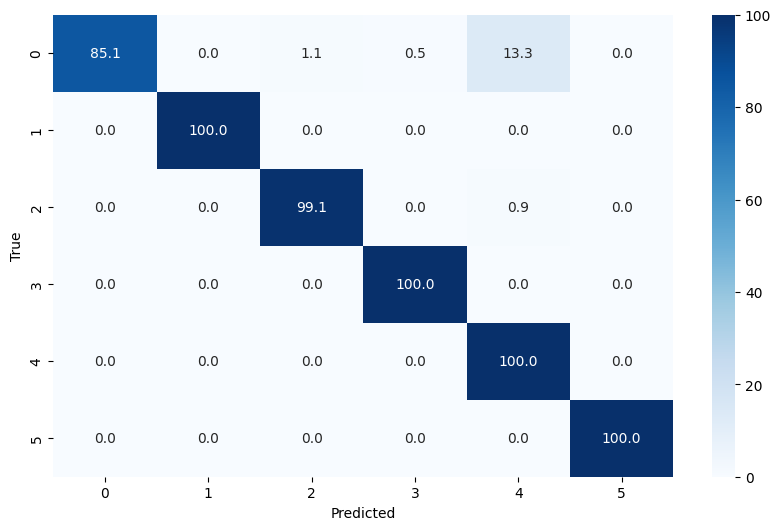

In [57]:
plot_confusion_matrix(trained_model, X_test, y_test)

### ⭐ Feature Importances


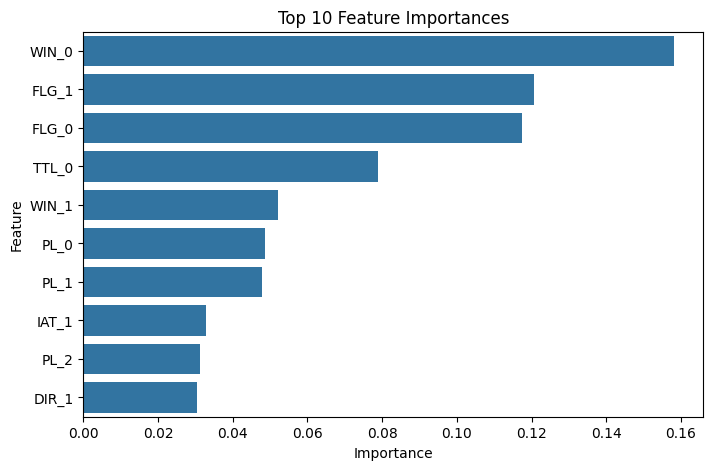

In [58]:
plot_feature_importances(trained_model, X.columns)